In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np

from rtree import index
from utils import *

In [2]:
G = ox.save_load.load_graphml(filename="Singapore_drive.graphml")
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# get 1 source
source = nodes['osmid'].values[5]
# get 1 target
target = nodes['osmid'].values[-5]

In [3]:
# Fill in all nodes to find neighbours
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']

for node, x, y in zip(node_id, xx, yy):
    idx.insert(int(node), (x,y,x,y))

In [4]:
orig_point = nodes[nodes['osmid'] == source].geometry.values[0]
target_point = nodes[nodes['osmid'] == target].geometry.values[0]
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

## Start

In [5]:
def bingo(s, t):
    # Find all nodes within 500m from candidate sources and destinations
    candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
    candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

    euclidean = get_length_dict(nodes, candidate_source, candidate_dest)  
    h_pair = hybrid_search(nodes, euclidean)
    h_len, h_route = nx.single_source_dijkstra(G, h_pair[0], h_pair[1], weight='ETA')
    
    mh_pair = modified_hybrid_search(nodes, euclidean)
    mh_len, mh_route = nx.single_source_dijkstra(G, mh_pair[0], mh_pair[1], weight='ETA')
    
    return (h_len, h_route, mh_len, mh_route) 

## Average-peak

In [6]:
h_len, h_route, mh_len, mh_route = bingo(source, target)

In [9]:
print("Time taken for route using hybrid search: {} minutes".format(h_len))
print("Time taken for route using modified hybrid search: {} minutes".format(mh_len))

Time taken for route using hybrid search: 28 minutes
Time taken for route using modified hybrid search: 34 minutes


## Plot!

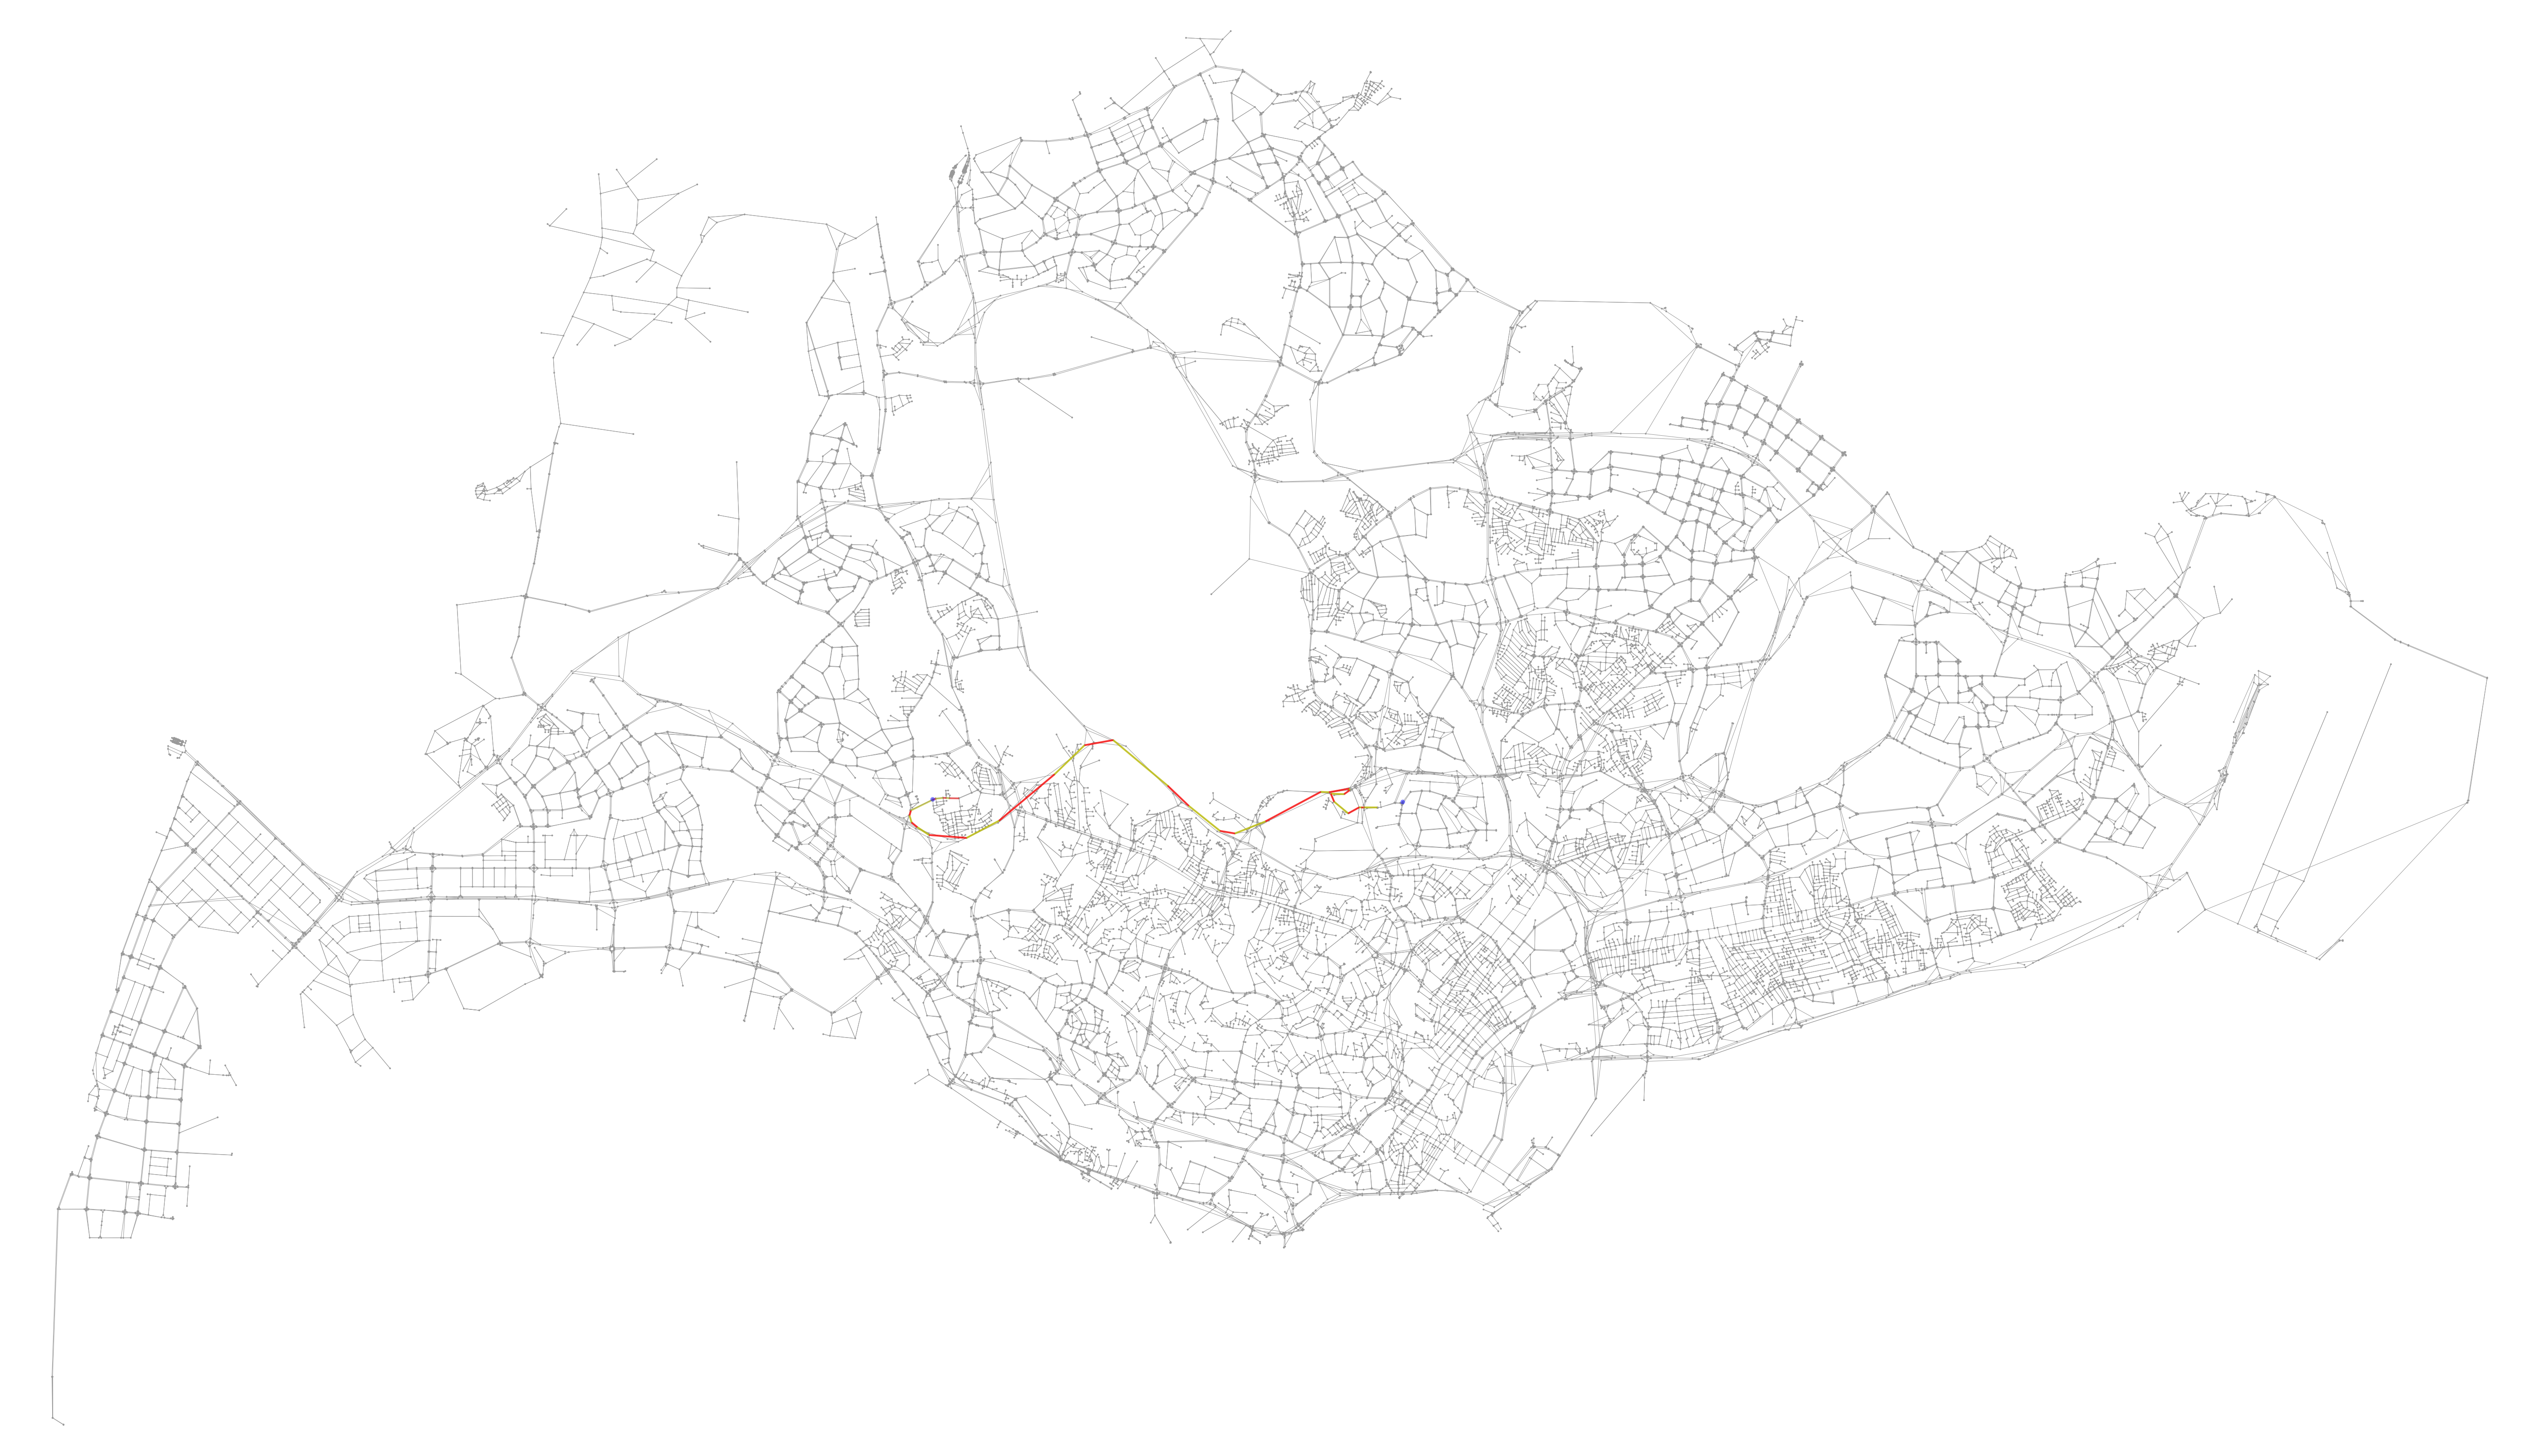

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph_routes(G, routes = [h_route, mh_route], route_color= ['r', 'y'], orig_dest_points=[orig_xy, target_xy], fig_height=100, fig_width=100)
plt.tight_layout()